In [0]:
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz
from time import time
import dask.array as da
from dask.distributed import Client, LocalCluster
from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import maps
from SimPEG import dask
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils.drivers import create_nested_mesh
from SimPEG import (
    maps,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
    objective_function,
    data
)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

save_file = False

def create_tile_em_misfit(sources, obs, uncert, global_mesh, global_active, tile_id, mstart, use_global=False):
    local_survey = fdem.Survey(sources)

    electrodes = []
    for source in sources:
        electrodes += [source.location]
        electrodes += [receiver.locations for receiver in source.receiver_list]
    electrodes = np.vstack(electrodes)
    local_survey.dobs = obs
    local_survey.std = uncert

    # Create tile map between global and local
    if use_global:
        local_mesh = global_mesh
        local_active = global_active
        local_map = maps.IdentityMap(nP=int(local_active.sum()))
    else:
        local_mesh = create_nested_mesh(
            electrodes, global_mesh,
        )
        local_map = maps.TileMap(global_mesh, global_active, local_mesh)
        local_active = local_map.local_active

    actmap = maps.InjectActiveCells(
        local_mesh, indActive=local_active, valInactive=np.log(1e-8)
    )
    expmap = maps.ExpMap(local_mesh)
    mapping = expmap * actmap
    # Create the local misfit
    max_chunk_size = 256
    simulation = fdem.simulation.Simulation3DMagneticFluxDensity(
        local_mesh, survey=local_survey, sigmaMap=mapping,
        Solver=Solver,
#         chunk_format="row",
#         max_chunk_size=max_chunk_size,
#         workers=workers
    )
    simulation.sensitivity_path = './sensitivity/Tile' + str(tile_id) + '/'
#     print(simulation.getSourceTerm().shape)
    data_object = data.Data(
        local_survey,
        dobs=obs,
        standard_deviation=uncert,
    )
    data_object.dobs = obs
    data_object.standard_deviation = uncert
    local_misfit = data_misfit.L2DataMisfit(
        data=data_object, simulation=simulation, model_map=local_map
    )
    local_misfit.W = 1 / uncert

    return local_misfit


## Line Source Simulation

Start by creating receivers, grounded line source path, mapping and mesh for simulation.
Then using the line source calculate the forward data.

/Users/juan/anaconda3/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55841 instead
  http_address["port"], self.http_server.port


Number of rx's:  81


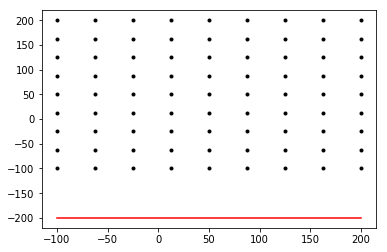

In [0]:
cluster = LocalCluster(processes=False)
client = Client(cluster)

xx, yy = np.meshgrid(np.linspace(-3000, 3000, 101), np.linspace(-3000, 3000, 101))
zz = np.zeros(np.shape(xx))
topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Frequencies being predicted
frequencies = [1, 32, 256]

# Defining transmitter locations
N = 2
xtx, ytx, ztx = np.meshgrid(np.linspace(-200, 200, 9), np.linspace(-200, 200, 1), [40])
source_locations = np.array(
    [[-100, -200, 0],[50, -200, 0],[100, -200, 0],[200, -200, 0]]
)


# np.savetxt("Receivers.dat", source_locations)
ntx = np.size(xtx)

# Define receiver locations
N = 9
xrx, yrx, zrx = np.meshgrid(np.linspace(-100, 200, N), np.linspace(-100, 200, N), [20])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]
print("Number of rx's: ", receiver_locations.shape[0])

plt.plot(source_locations[:, 0], source_locations[:, 1], '-r')
plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], '.k')
plt.show()

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(len(frequencies)):

        # Define receivers of different type at each location
        bzr_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "z", "real"
        )
        bzi_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "z", "imag"
        )
        
        byr_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "y", "real"
        )
        byi_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "y", "imag"
        )
        
        bxr_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "x", "real"
        )
        bxi_receiver = fdem.receivers.PointMagneticFluxDensity(
            receiver_locations, "x", "imag"
        )
#         receivers_list = [bzr_receiver, bzi_receiver]
        
        exr_receiver = fdem.receivers.PointElectricField(
            receiver_locations, "x", "real"
        )
        exi_receiver = fdem.receivers.PointElectricField(
            receiver_locations, "x", "imag"
        )
        eyr_receiver = fdem.receivers.PointElectricField(
            receiver_locations, "y", "real"
        )
        eyi_receiver = fdem.receivers.PointElectricField(
            receiver_locations, "y", "imag"
        )
        receivers_list = [bzr_receiver, bzi_receiver, byr_receiver, byi_receiver, bxr_receiver, bxi_receiver, exr_receiver, exi_receiver, eyr_receiver, eyi_receiver]

        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.LineCurrent(
                receiver_list=receivers_list,
                frequency=frequencies[ii],
                location=source_locations
            )
        )

survey = fdem.Survey(source_list)

In [0]:
dh = 25.0  # base cell width
dom_width = 3000.0  # domain width
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

# Define the base mesh
h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], x0="CCC")

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xyz, octree_levels=[0, 0, 0, 1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
mesh = refine_tree_xyz(
    mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
)

mesh = refine_tree_xyz(
    mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
)

# Refine core mesh region
xp, yp, zp = np.meshgrid([-250.0, 250.0], [-250.0, 250.0], [-300.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 4], method="box", finalize=False)

mesh.finalize()

# Conductivity in S/m (or resistivity in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)
block_conductivity = np.log(1e1)

# Find cells that are active in the forward modeling (cells below surface)
active_cells = surface2ind_topo(mesh, topo_xyz)

# Define mapping from model to active cells
expmap = maps.ExpMap(mesh)
model_map = expmap * maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Define model. Models in SimPEG are vector arrays
model = background_conductivity * np.ones(active_cells.sum())
mstart = background_conductivity * np.ones(active_cells.sum())
ind_block = (
    (mesh.gridCC[active_cells, 0] < 50.0)
    & (mesh.gridCC[active_cells, 0] > -50.0)
    & (mesh.gridCC[active_cells, 1] < 50.0)
    & (mesh.gridCC[active_cells, 1] > -50.0)
    & (mesh.gridCC[active_cells, 2] > -275.0)
    & (mesh.gridCC[active_cells, 2] < -75.0)
)
model[ind_block] = block_conductivity

create the simulation and calculate forward data

In [0]:
simulation_g = fdem.simulation.Simulation3DMagneticFluxDensity(
        mesh, survey=survey, sigmaMap=model_map, Solver=Solver
    )
global_data = simulation_g.make_synthetic_data(model, relative_error=0.0, noise_floor=5e-14, add_noise=True)

In [0]:
survey.dobs = global_data.dobs
survey.std = np.abs(survey.dobs * global_data.relative_error) + global_data.noise_floor

print(survey.dobs.shape, receiver_locations.shape)

(2430,) (81, 3)


plot up results of the electric and magnetic fields

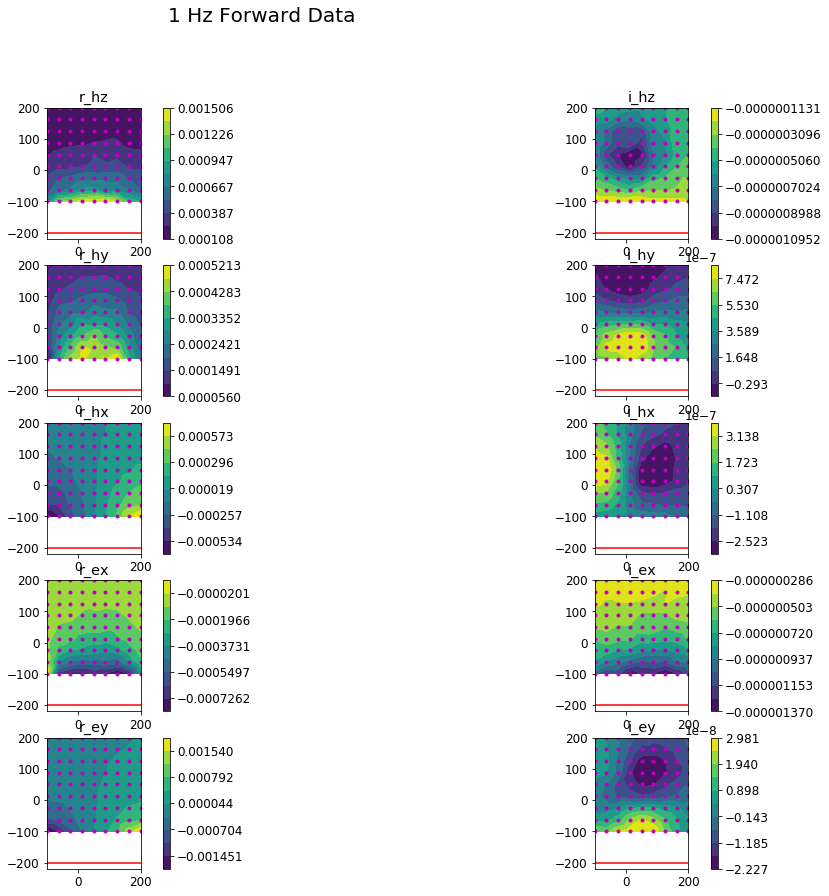

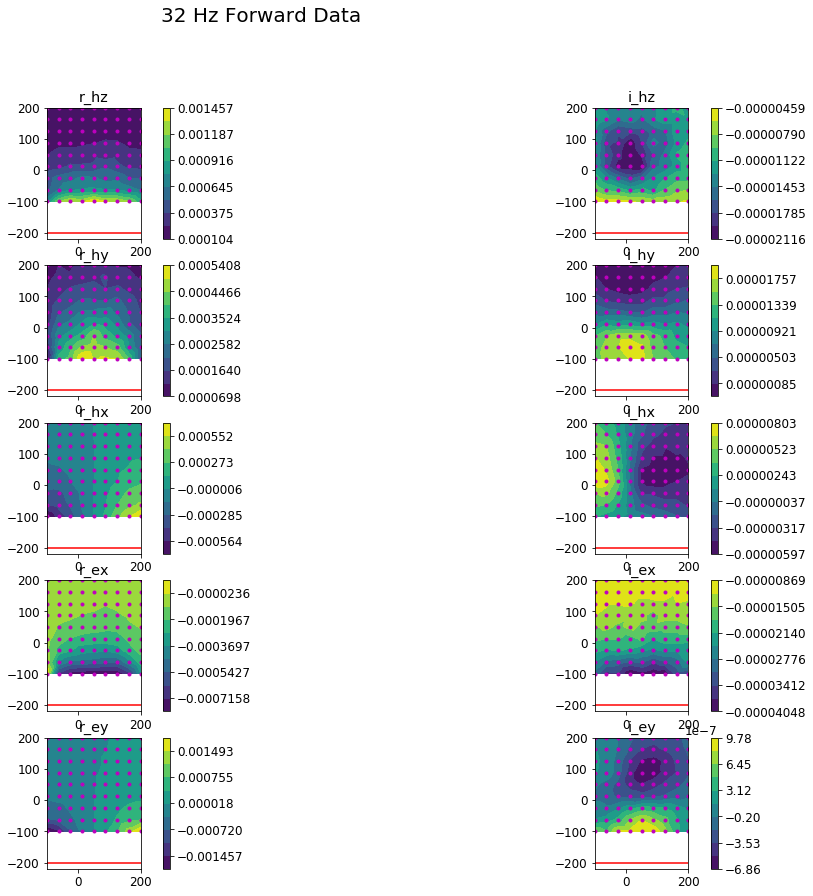

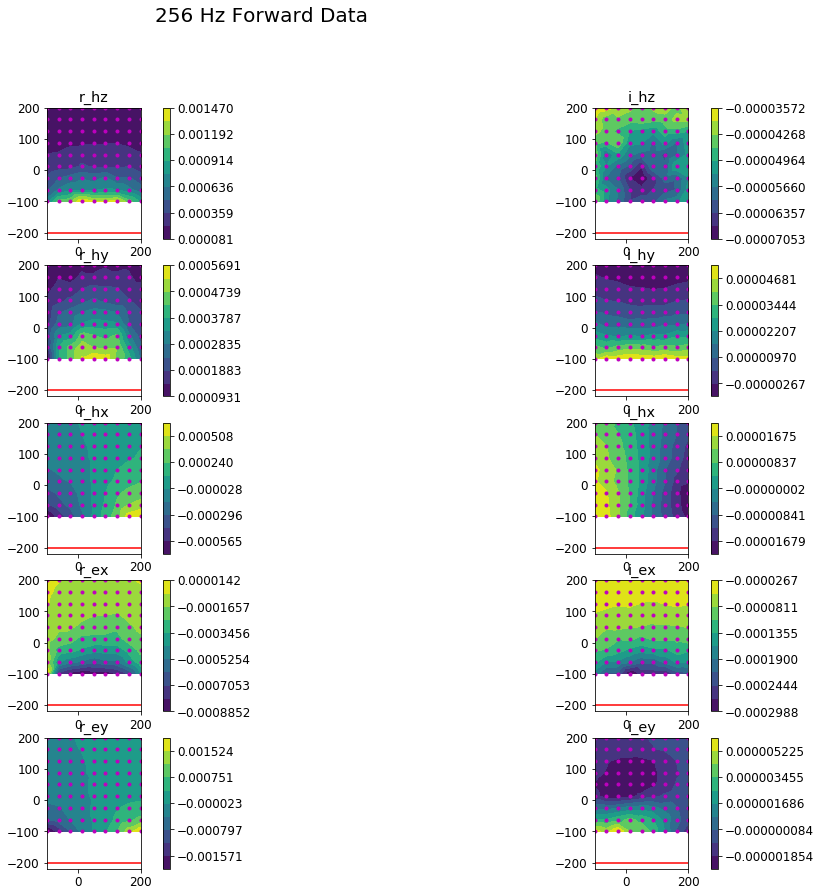

In [0]:
num_station = receiver_locations.shape[0]
num_sets = int(survey.dobs.shape[0] / len(frequencies))
dnew = np.reshape(survey.dobs, (3, num_sets))
stdnew = np.reshape(survey.std, (3, num_sets))

cnt = 0

for freq in frequencies:
    cnt_comp = 0
#     comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['r_hz', 'i_hz','r_hy', 'i_hy','r_hx', 'i_hx', 'r_ex', 'i_ex', 'r_ey', 'i_ey']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(5,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receiver_locations, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        ax.plot(source_locations[:, 0], source_locations[:, 1], '-r')
        ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], '.m')
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f'{freq} Hz Forward Data', fontsize='20')
plt.show()

## Tensor CSAMT

Here let put together the line source with MT tensor recievers

In [0]:
from SimPEG.electromagnetics import natural_source as ns
# Create receivers
receiver_list_ct = []
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    receiver_list_ct.append(ns.Rx.Point3DImpedance(receiver_locations, rx_orientation, 'real'))
    receiver_list_ct.append(ns.Rx.Point3DImpedance(receiver_locations, rx_orientation, 'imag'))


# Source list
source_list_ct = [
    fdem.sources.LineCurrent(
                receiver_list=receiver_list_ct,
                frequency=frequencies[ii],
                location=source_locations)
    for freq in frequencies
]


survey_ct = fdem.Survey(source_list)

Now to create the simultation a calculate forward data

In [0]:
# Setup the problem object
simulation_csamt_tensor = ns.simulation.Simulation3DPrimarySecondary(mesh, survey=survey,
                                           sigmaMap=model_map,
                                           sigmaPrimary=model_map * mstart,
                                           solver=Solver)

simulation_csamt_tensor.model = model

# Assign uncertainties
# make data object
csamt_tensor_data = simulation_csamt_tensor.make_synthetic_data(model, relative_error=0.0, noise_floor=5e-3, add_noise=False)

survey_ct.dobs = csamt_tensor_data.dobs
survey_ct.std = np.abs(survey_ct.dobs * csamt_tensor_data.relative_error) + csamt_tensor_data.noise_floor

plot the forward data

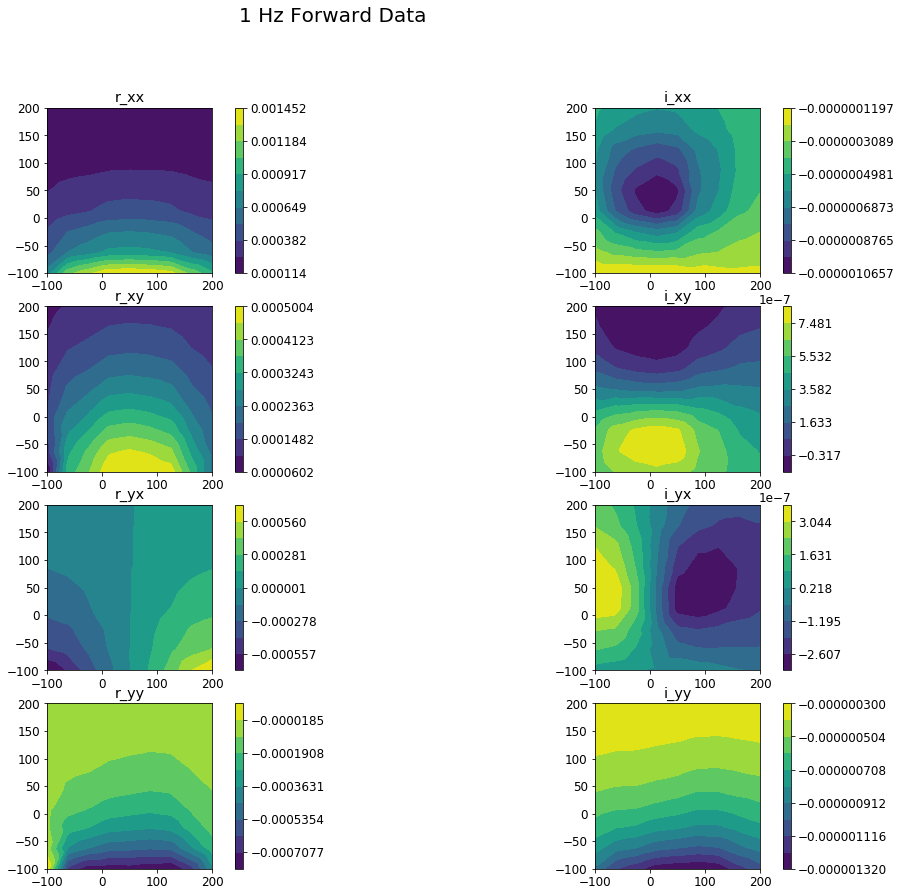

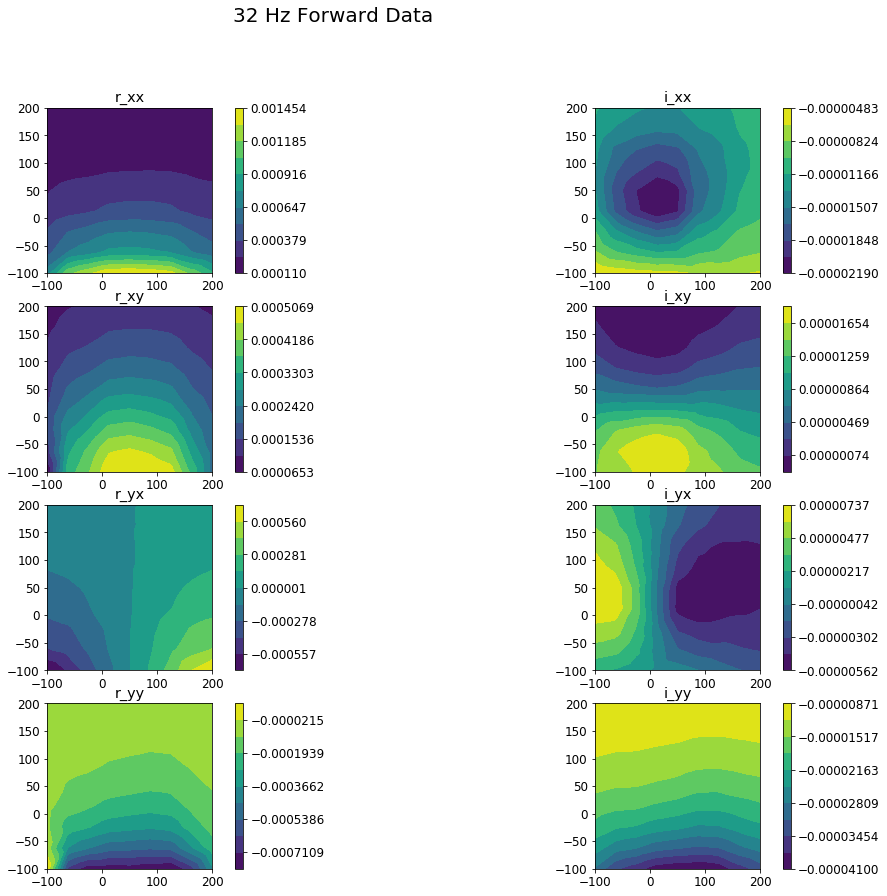

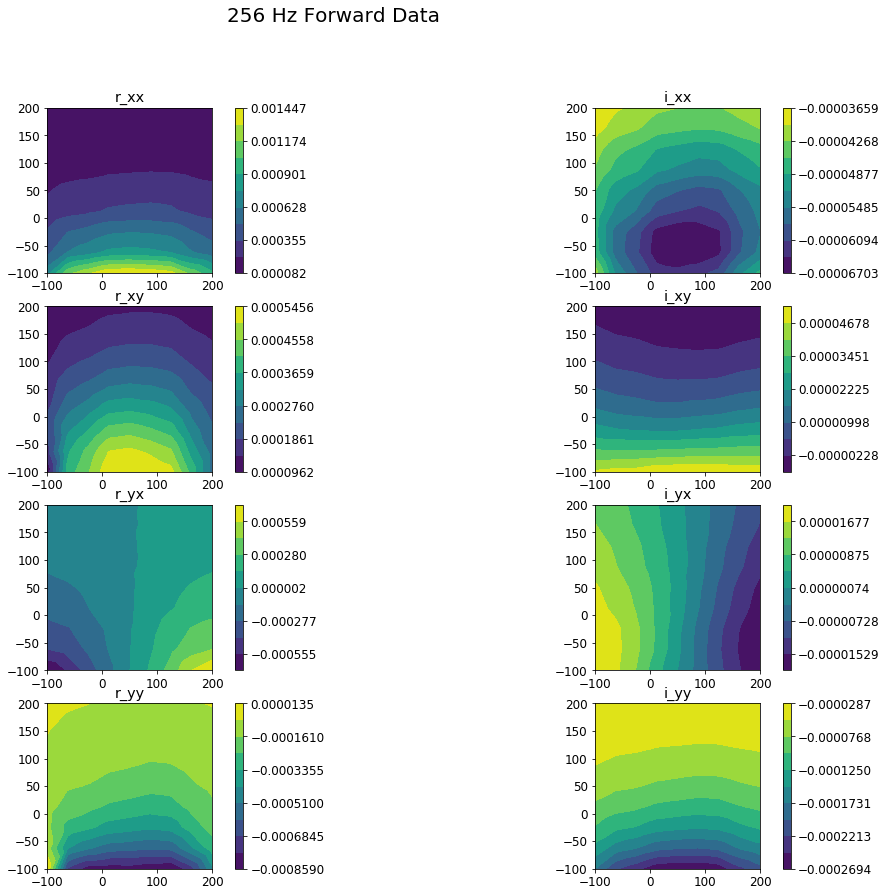

In [0]:
num_station = receiver_locations.shape[0]
num_sets = int(survey_ct.dobs.shape[0] / len(frequencies))
dnew = np.reshape(survey_ct.dobs, (3, num_sets))
stdnew = np.reshape(survey_ct.std, (3, num_sets))

cnt = 0

for freq in frequencies:
    cnt_comp = 0
    comps_ = ['r_xx', 'i_xx', 'r_xy', 'i_xy', 'r_yx', 'i_yx', 'r_yy', 'i_yy']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
#         pert = 1e-3  # np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 20)
#         if comps_[rx_orientation][-2:] == 'xx':
#             stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] + pert
#         elif comps_[rx_orientation][-2:] == 'yy':
#             stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] + pert
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receiver_locations, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f'{freq} Hz Forward Data', fontsize='20')
plt.show()

## True model

(-150, 250)

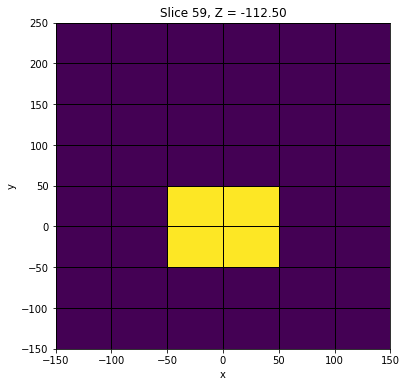

In [0]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh.plotSlice(model, grid=True, normal="z", ind=59, ax=ax)
ax.set_xlim([-150, 150])
ax.set_ylim([-150, 250])
# ax.plot(electrodes[:, 0], electrodes[:, 1], '.r')

# fig = plt.figure(figsize=(6, 6))
# ax1 = fig.add_subplot(111)
# mesh.plotSlice(model, grid=True, normal="y", ind=5, ax=ax1)
# plt.show()

## Inversion

[INFO] Getting things started on inversion...

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solver_opts as the Simulation3DMagneticFluxDensity problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.93e+01  2.70e+07  0.00e+00  2.70e+07    8.61e+07      0              
   1  9.66e+00  9.22e+06  2.60e+05  1.42e+07    1.13e+07      0              
   2  4.83e+00  1.02e+07  2.03e+05  1.22e+07    3.83e+06      0   Skip BFGS  
   3  2.42e+00  5.28e+06  6.66e+05  8.50e+06    3.84e+06      0   Skip BFGS  
   4  1.21e+00  4.37e+06  9.59e+05  6.68e+06    6.81e+06      0   Skip BFGS  
   5  6.04e-01  2.64e+06  1.63e+06  4.61e+06    3.19e+06      0   Skip BFGS  
------------------------- STOP! -------------------

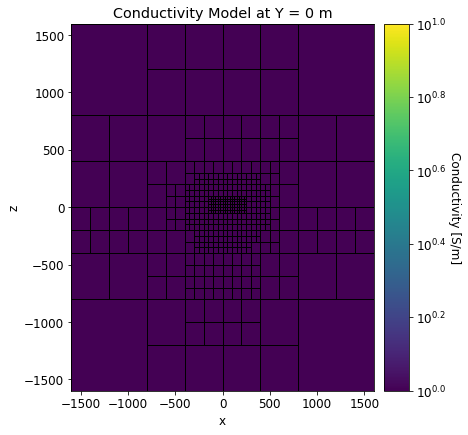

In [0]:
# Plot Resistivity Model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

ploting_map = expmap * maps.InjectActiveCells(mesh, active_cells, np.nan)
ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.85])
mesh.plotSlice(
    np.log10(ploting_map * model),
    normal="Y",
    ax=ax1,
    ind=int(mesh.hx.size / 2),
    grid=True,
)
ax1.set_title("Conductivity Model at Y = 0 m")

ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.85])
cbar = mpl.colorbar.ColorbarBase(
    ax2, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

simulation_g = fdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, Solver=Solver
)


# Compute predicted data for a your model.
# dpred = simulation.dpred(model)
global_data = simulation_g.make_synthetic_data(model, relative_error=0.05, noise_floor=5e-14, add_noise=True)


# Split the problem in tiles (over frequency)
survey.dobs = global_data.dobs
survey.std = np.abs(survey.dobs * global_data.relative_error) + global_data.noise_floor

######### To run with tiling
idx_start = 0
idx_end = 0
# do every 5 sources
cnt = 0
local_misfits = []
# for ii, frequency in enumerate(survey.frequencies):
#     idx_start, idx_end = ii*ntx, ii*ntx+2*ntx
#     sources = survey.get_sources_by_frequency(frequency)
#     dobs = survey.dobs[idx_start:idx_end]
# #         print(dobs.shape, len(src_collect))
#     delayed_misfit = create_tile_em_misfit(
#         sources,
#         survey.dobs[idx_start:idx_end],
#         survey.std[idx_start:idx_end],
#         mesh, active_cells, ii, model
#     )
#     local_misfits += [delayed_misfit]

########## To run without tiling
local_misfits = [data_misfit.L2DataMisfit(
    data=global_data, simulation=simulation_g
)]
local_misfits[0].W = 1 / survey.std
local_misfits[0].simulation.model = model
global_misfit = objective_function.ComboObjectiveFunction(
                local_misfits
)

# for local_misfit in global_misfit.objfcts:
#     local_misfit.simulation.model = local_misfit.model_map @ model
#     local_misfit.simulation.Jmatrix

use_preconditioner = False
coolingFactor = 2
coolingRate = 1
beta0_ratio = 1e1

# Map for a regularization
regmap = maps.IdentityMap(nP=int(active_cells.sum()))
reg = regularization.Sparse(mesh, indActive=active_cells, mapping=regmap)

print('[INFO] Getting things started on inversion...')
# set alpha length scales
reg.alpha_s = 1 # alpha_s
reg.alpha_x = 1
reg.alpha_y = 1
reg.alpha_z = 1
reg.mref = background_conductivity * np.ones(active_cells.sum())

opt = optimization.ProjectedGNCG(
    maxIter=5, upper=np.inf, lower=-np.inf, tolCG=1e-4,
    maxIterCG=10,
)
invProb = inverse_problem.BaseInvProblem(global_misfit, reg, opt)
beta = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=coolingRate
)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
target = directives.TargetMisfit()
target.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
saveIterVar = directives.SaveOutputEveryIteration()
# Need to have basice saving function
if use_preconditioner:
    update_Jacobi = directives.UpdatePreconditioner()
    updateSensW = directives.UpdateSensitivityWeights()
    # updateWj = Directives.Update_Wj()
    # directiveList = [
    #     beta, betaest, target, updateSensW, saveIter, update_Jacobi
    # ]
    directiveList = [
        updateSensW, beta, betaest, target, update_Jacobi
    ]
else:
    directiveList = [
        beta, betaest, target
    ]
inv = inversion.BaseInversion(
    invProb, directiveList=directiveList)
opt.LSshorten = 0.5
opt.remember('xc')

# Run Inversion ================================================================
tc = time()
minv = inv.run(mstart)
rho_est = model_map * minv
print("Total runtime: ", time()-tc)
# np.save('model_out.npy', rho_est)

mesh.writeUBC('OctreeMesh-test.msh', models={'ubc.con': rho_est})

(<matplotlib.collections.PolyCollection at 0x7ffb5e733898>,)

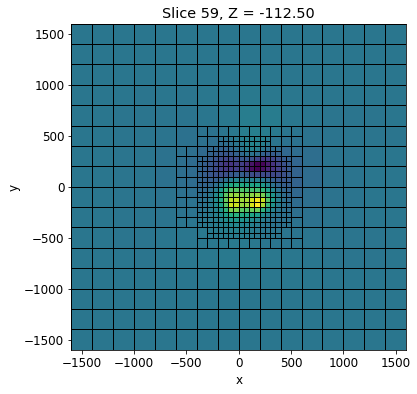

In [0]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh.plotSlice(rho_est, grid=True, normal="z", ind=59, ax=ax)